# Classify ground type from sentinel-2 images
In this laboration Sentinel-2 images containing 12 bands will be used in combination with another dataset from Naturvårdsverket. 

This laboration has many similarities with the previous. But we will also look more closely into the results and introduce concepts as True positive, False positive, True negative and false negative. And looka at the data to see what the model is good and bad at. 

We will have a closing discussion on how this laboration could improve in different ways by feature engineering, data selection for the trainingset.


In [1]:
# Import the libraries needed
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns

from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder #Used to convert or ground type class
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import normalize #
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Load the file that contains all the data prepared for the lab
file=np.load('./data/ROI3_2_1_2018_smaland_virserum/MB_ROI3_2_1_2018_smaland_virserum_13Band.npz')

# NMD
To start with we need to look at the NMD data that we are going to use as the anwsere while we are training and validating or model. A good start is to plot it and se how i looks. 

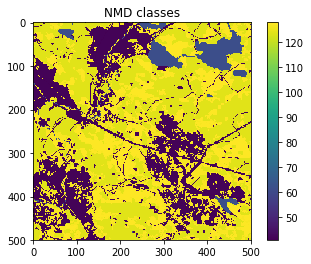

In [3]:
NMD=file['orig_classed_img'] #
all_bands=file['raw_img']
plt.imshow(NMD)
plt.title('NMD classes')
plt.colorbar()
plt.show()

Those numerica values doesn't make sense and the colormap does not help us to understand the landscape. But we can guess that dark blue is city and roads, blue is water and green to yellow is forests, crops and wetlands.

In the cell below we try to vizualize it a little better then the default.

It is not needed for this laboration to understand the `plot_ground` function it is a quite complicated function that uses some functions from `matplotlib`

Shape of NMD data (500, 500)


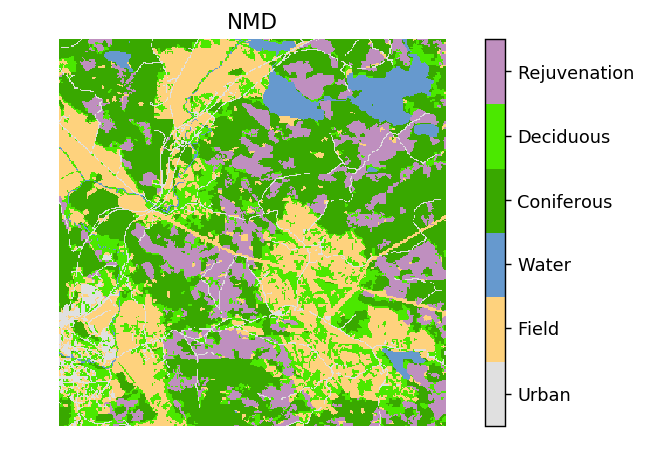

In [5]:
def plot_ground(Y, encoder,title):
    colormapping = { 41:[224, 224, 224],
                     42:[254, 210, 125],
                     62:[102, 153, 206],
                     124:[57, 168, 0],
                     127:[75, 232, 0],
                     128:[191,  143, 191]}
    cmap_colors = []

    for i in encoder.classes_:
        # The colors has to be converted into interval 0-1
        c = np.array(colormapping.get(i))/255.
        cmap_colors.append(c)
    
    cmap = colors.ListedColormap(cmap_colors)
    ticks=encoder.classes_.copy()
    bounds=[ticks[0]-0.5]
    
    i=1
    while len(bounds)<len(ticks):
        bounds.append(ticks[i]-0.5)
        try:
            #replace ticks to be in the middle of the interval
            ticks[i]=(ticks[i]+ticks[i+1])/2.
        except:
            i+=0
        i+=1
    bounds.append(ticks[i-1]+0.5)

    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig2 = plt.figure(dpi=128,figsize=(8, 4))
    plt.title(title)
    ax1= plt.imshow(Y.reshape((500,500)), interpolation='nearest',
                        cmap=cmap, norm=norm)
    plt.axis('off')
    cbar = fig2.colorbar(ax1, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks)
    cbar.ax.set_yticklabels(['Urban', 'Field','Water','Coniferous','Deciduous','Rejuvenation'])
    plt.show()
    
encoder = LabelEncoder()
print('Shape of NMD data',NMD.shape)
##
NMD_df=pd.DataFrame()
NMD_df['NMD'] = NMD.flatten()
class_convertion = [('Urban',41,), ('Field',42),('Water',62),('Coniferous',124),('Deciduous',127),('Rejuvenation',128)]
# Convert the NMD values to its label
##
encoder.fit(np.unique(NMD))
plot_ground(NMD, encoder,'NMD')


The script might have been a little complicated and might not give the most value for the lab. But it was necesary in order to make the data understandable. Specially in the long run when we evaluating the model. 

We can illustrate the amount of data by a bar plot.


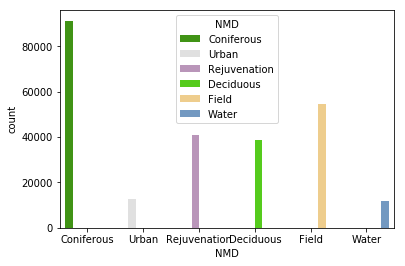

In [6]:
NMD_df=pd.DataFrame()
NMD_df['NMD'] = NMD.flatten()
class_convertion = [('Urban',41,), ('Field',42),('Water',62),('Coniferous',124),('Deciduous',127),('Rejuvenation',128)]
# Convert the NMD values to its label
for pair in class_convertion:
    NMD_df.loc[NMD_df['NMD']==pair[1]]=pair[0]

class_colors = [np.array([224, 224, 224])/255., 
         np.array([254, 210, 125])/255., 
         np.array([102, 153, 206])/255., 
         np.array([57, 168, 0])/255., 
         np.array([75, 232, 0])/255., 
         np.array([191,  143, 191])/255.]

newPal   = dict(Urban = class_colors[0], 
                Field = class_colors[1], 
                Water = class_colors[2], 
                Coniferous = class_colors[3], 
                Deciduous = class_colors[4], 
                Rejuvenation = class_colors[5])

ax = sns.countplot(x='NMD', data=NMD_df, hue='NMD',
                 palette=newPal)

From the barplot we can see that it is a quite significant difference in the amount of datapoints in each class. Take a moment and think about the following questions.

1. How can an uneven distribution between the classes in the trainingset impact the final model?
2. What might be the possible solutions to attack such a problem?
3. How can we know for certain that the classed image is correct?

Those questions are very important to keep track on. For example if a company wants to predict need of maintanence with ML/AI but but there might only be one or two days out of 1000 that contains data of the machine running unevenly due to bad components.

# Exploration of the satellite images
The satellite images from Sentinel-2 contains of 11-12 bands depending on year of photo and processing level of the photo. It is band 10 that is missing if there is only 11 bands. Each band is a registration of a specific wavelength. Note that different bands has different resolutions. 

If you want to read a little more about the sensors [Wikipedia](https://en.wikipedia.org/wiki/Sentinel-2) has a good overview. If you want more detailed information [ESA](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi) will  provide you with more then enough data.

First we look at the data and try to get some idea of the data.


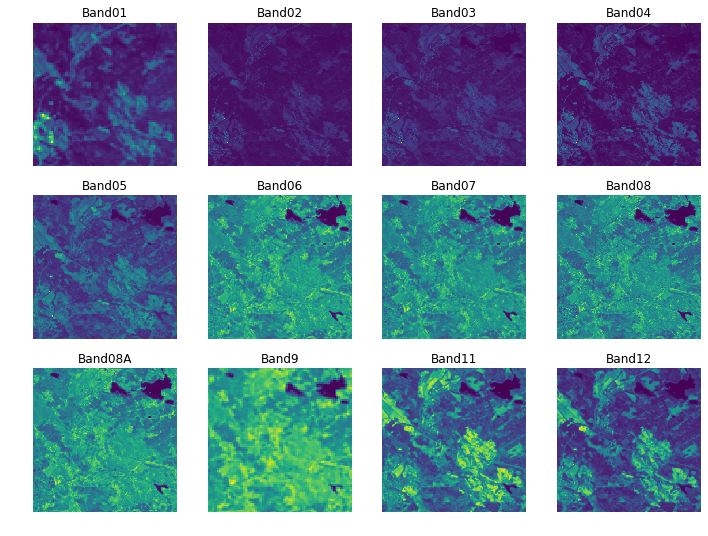

In [7]:
Bands=['Band01','Band02','Band03','Band04','Band05','Band06','Band07','Band08','Band08A','Band9','Band11','Band12']

nrows, ncols = 3, 4
fig = plt.figure(figsize=(12,9))    
i=0
for band in Bands:
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.imshow(all_bands[i,:,:])
    ax.title.set_text(band)
    ax.axis('off')
    i+=1
plt.show()

Band 2, 3 and 4 which are all in the visible spectrum have in common that they are very dark due to some very bright pixles in the SW corner. 

If you want and have time you can elaborate with line `ax.imshow(all_bands[i,:,:])` in the cell above and add  `, vmin=0, vmax=1000` before the trailing parathesis to improve dynamics of the image. 



In [8]:
#Check what values that are in the matrix
print(np.unique(NMD))

[ 41  42  62 124 127 128]


In order to put our data into a dataframe it has to be restructured into a 2d matrix shaped dataset. Where each column is all the pixels from one band.

In [9]:
X = all_bands.reshape((12, np.shape(all_bands)[1]*np.shape(all_bands)[2])).T
Y = NMD.reshape((np.shape(NMD)[0]*np.shape(NMD)[1],1)).astype(int)

In [10]:
Bands=['Band01','Band02','Band03','Band04','Band05','Band06','Band07','Band08','Band08A','Band09','Band11','Band12','NMD']

data1 = np.c_[X,Y]
df = pd.DataFrame(data1,columns=Bands)

Calculate the correlation matrix and name the correlation matrix `corr`

In [11]:
# Calculate the correlation here
corr=df.corr()

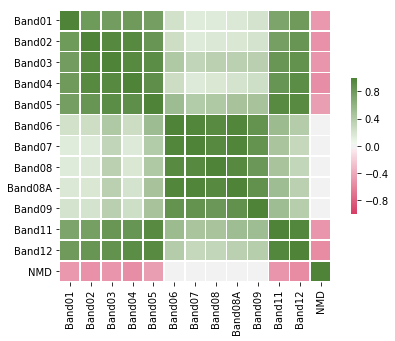

In [12]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))


# Draw the heatmap with the mask and correct aspect ratio
cmap = sns.diverging_palette(2, 120, as_cmap=True)
sns.heatmap(corr,  vmax=1,vmin=-1, center=0, cmap=cmap,# mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Show the correlation matrix with 2 deciamls

Clearly there are some bands that are quite strongly correlated with each other. 

Delete bands that does not provide a lot of new data

1. Create a list with all significant bands

2. Calculate the correlation of those bands with the `corr()` method

3. Make the heat map plot as above and look 

In [13]:
# create a list with significant bands and name it sig_bands
sig_bands=['Band01','Band02','Band08A','Band08','Band09','Band11']

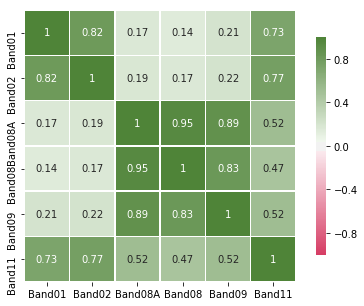

In [14]:
import numpy as np

corr2=df[sig_bands].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2,  vmax=1,vmin=-1, center=0,cmap=cmap,# mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True)
plt.show()

Look at the correlation matrix with 2 decimals

In [ ]:
# Write code for looking at the correlation matrix here

Look at the pair plot with only the significant bands. Color them by the NMD value.

### Split the data into training, test and validation data with only the selected variables

In [15]:
# Normalize the data before splitting it train test and validation set.
data = df#.sample(frac=1).reset_index(drop=True)
data.iloc[:,:-1] = normalize(df.iloc[:,:-1].values,axis=0)

train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

# Split the data into train test and validation sets.
train_x = train.iloc[:,:-1].values
train_y = train.iloc[:,-1].values

test_x = test.iloc[:,:-1].values
test_y = test.iloc[:,-1].values

validate_x = validate.iloc[:,:-1].values
validate_y = validate.iloc[:,-1].values

# Convert the label to a understandable format for tensorflow
le = preprocessing.LabelEncoder()
le.fit(train_y)

train_label = le.transform(train_y)
train_y = tf.keras.utils.to_categorical(train_label,num_classes=6)

test_label = le.transform(test_y)
test_y = tf.keras.utils.to_categorical(test_label,num_classes=6)

validate_label = le.transform(validate_y)
validate_y = tf.keras.utils.to_categorical(validate_label, num_classes=6)

### Create the neural net with 2hidden layers and 5-10 nodes in each 
Create a neural net with dropout layers and a reasonable amount of neurons in each layer.

Name the model into variable `model` and store the fitting into `history`

In [16]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10,input_dim=12,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(6,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
history = model.fit(train_x,train_y,validation_data=(validate_x, validate_y),batch_size=512,epochs=50,verbose=1)


Train on 150000 samples, validate on 50000 samples
Epoch 1/50
150000/150000 [==============================] - 1s 5us/sample - loss: 1.6640 - acc: 0.3485 - val_loss: 1.5767 - val_acc: 0.3662
Epoch 2/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.5761 - acc: 0.3651 - val_loss: 1.5614 - val_acc: 0.3662
Epoch 3/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.5364 - acc: 0.4034 - val_loss: 1.4759 - val_acc: 0.4590
Epoch 4/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.4171 - acc: 0.5004 - val_loss: 1.3211 - val_acc: 0.5437
Epoch 5/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.2938 - acc: 0.5279 - val_loss: 1.2110 - val_acc: 0.5549
Epoch 6/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.2200 - acc: 0.5392 - val_loss: 1.1513 - val_acc: 0.5673
Epoch 7/50
150000/150000 [==============================] - 1s 4us/sample - loss: 1.1822 - acc: 0.5484 - val_

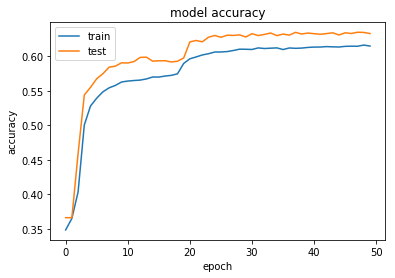

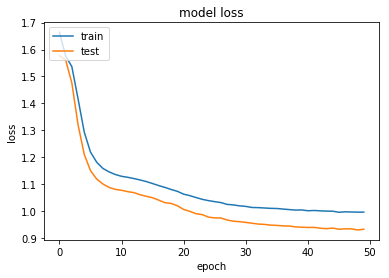

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

For simplicity lets predict the entire image that we trained or model on and se how it compares the the correct values.

In a real case scenario we should evaluate the model with something unknown so it would be better to  evaluate it with another image

250000/250000 [==============================] - 0s 1us/sample
[3 3 3 ... 3 3 3]
[ 41  42  62 124 127 128]


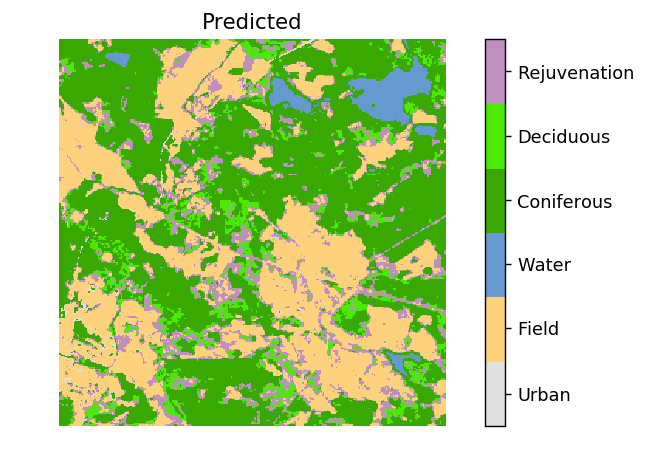

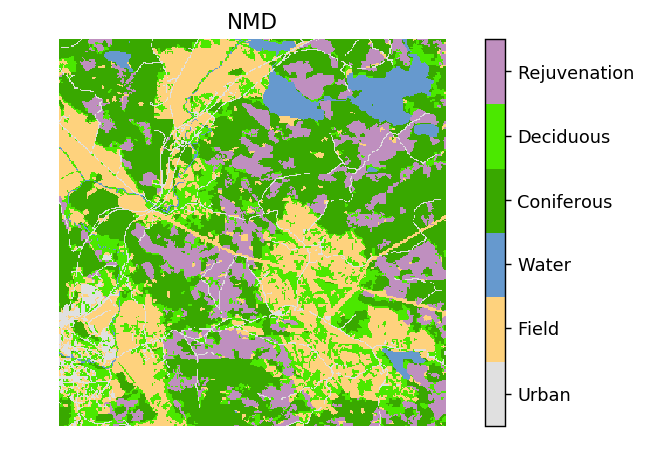

In [18]:

X=data.copy()
Y=X['NMD']#data.copy()
X.pop('NMD')
output = model.predict_classes(X, verbose=1,batch_size=512)
print(output)
temp = to_categorical(output)
out_enc = le.inverse_transform(np.argmax(temp,axis=1))
print(np.unique(out_enc))


plot_ground(out_enc.reshape((500,500)),encoder,'Predicted')
plot_ground(Y.values.reshape((500,500)),encoder,'NMD')

The overall impression is that the method works pretty well. But the model predicts a very small amount of Rejuvenation forest. Those are either predicted as fields or forest. Also there is quite a lot of mix between Coniferous and Deciduous forests. 

The water areas are well predicted but there is small lake in northen middle part of the image that is missing from the predicted region. Most likely this lake is dried out when the satelite image is taken.

Roads are not predicted very well but the city is well described. 

How come that the roads are not predicted so well?

# Evaluate the model
In binary classification problems ROC curves can be used to evaluate the model. In multiple classification problems this could be possible. But would need one ROC curve for each class. Instead confusion matrices are used, where each row is the actual class and the column represents the prediction of the mode. 

Confusion matrix is a function in sklearn.

In [19]:
conf_mat = confusion_matrix(Y.values.flatten(), out_enc)

In [20]:
out_df = pd.DataFrame(out_enc,columns=['pred'])
for pair in class_convertion:
    out_df.loc[out_df['pred']==pair[1]] = pair[0]

pd.crosstab(NMD_df.NMD, out_df.pred, rownames=['Actual Ground Type'], colnames=['Predicted Ground Type'])

Predicted Ground Type,Coniferous,Deciduous,Field,Rejuvenation,Urban,Water
Actual Ground Type,,,,,,
Coniferous,87282,1564,479,1862,44,46
Deciduous,9062,9188,9406,11012,95,0
Field,2495,1788,43234,6883,171,0
Rejuvenation,9918,6272,14447,10288,36,4
Urban,2876,429,7252,1448,560,0
Water,3699,381,87,564,6,7122


In the breast cancer laboration we trusted the dataset and expected it to be correct so we focused on how to improve the model. In this case we should not trust the NMD data to be accurate. 

Below we look at the NMD water class and compare it to the predictions of the validation data. 


50000/50000 [==============================] - 0s 1us/sample


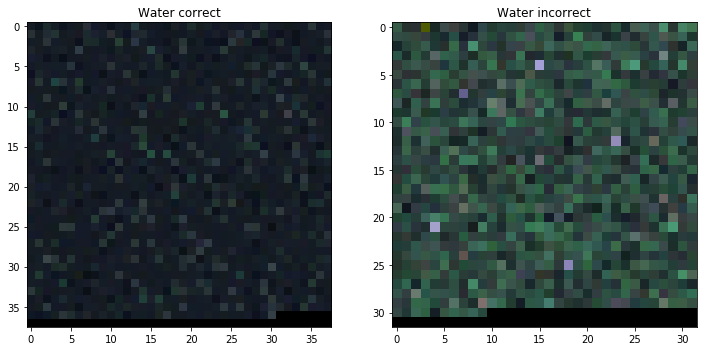

In [57]:
predict_from_validation = model.predict_classes(validate_x, verbose=1,batch_size=512)
water_pixels = validate.loc[(df['NMD']==62)]
temp = to_categorical(predict_from_validation)
predict_from_validation_class = le.inverse_transform(np.argmax(temp,axis=1))

validate['predicted'] = predict_from_validation_class

water_pixels_NMD = water_pixels.loc[validate['NMD']==62,['Band02','Band03','Band04','predicted']]

w_correct = water_pixels.loc[water_pixels_NMD['predicted']==62].copy()

w_false = water_pixels.loc[water_pixels_NMD['predicted']!=62].copy()


filters = [w_correct, w_false]
titles = ['Water correct', 'Water incorrect']
i = 0
fig,ax = plt.subplots(1,2,figsize=(12,6))
for vals in filters:
    rgb = vals[['Band02','Band03','Band04']].values#*5000
    s = np.shape(rgb)[0]
    rows = np.ceil(np.sqrt(s))
    cols = np.ceil(np.sqrt(s))

    collected_pixels = np.zeros((int(rows*cols),3))
    collected_pixels[:s,0] = rgb[:,2]
    collected_pixels[:s,1] = rgb[:,1]
    collected_pixels[:s,2] = rgb[:,0]
    collected_pixels = (200.*collected_pixels) #scale  r g b with 200 to make it reasonable in colormap.
    
    ax[i].imshow(collected_pixels.reshape((int(rows),int(rows),3)))
    ax[i].set_title(titles[i])
    #ax[i].axis('off')
    i += 1
plt.show()

From the images above we can conclude that quite a lot of the area in the NMD data that is classed as water is really somehting else. Therefor it is not possible to use only NMD to validate or model when it is trained. 

In order to create a better model it might be neccesary to clean the training data from incorrect classed water. 

W0602 20:13:25.689486 12680 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


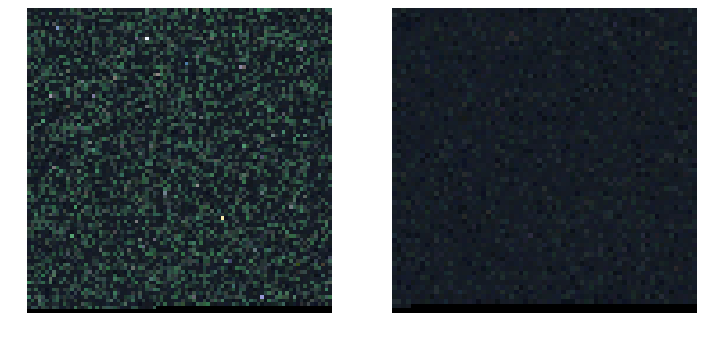

In [46]:
all_water = train.loc[(df['NMD']==62)]
filtered_water = train.loc[(df['NMD']==62) &(df['Band03']<0.0009)]
filters=[all_water,filtered_water]
i=0
fig,ax = plt.subplots(1,2,figsize=(12,6))
for vals in filters:
    rgb = vals[['Band02','Band03','Band04']].values#*5000
    s = np.shape(rgb)[0]
    rows = np.ceil(np.sqrt(s))
    cols = np.ceil(np.sqrt(s))

    collected_pixels=np.zeros((int(rows*cols),3))
    collected_pixels[:s,0]=rgb[:,2]
    collected_pixels[:s,1]=rgb[:,1]
    collected_pixels[:s,2]=rgb[:,0]
    collected_pixels=(200.*collected_pixels)
    
    ax[i].imshow(collected_pixels.reshape((int(rows),int(rows),3)))
    ax[i].axis('off')
    i+=1
plt.show()


In the left image we can see all pixels that are classed as water in the NMD data. Some of those appears to be quite green for beeing water. 

In the right picture only pixels lower then a certain threshold is shown.

W0602 20:13:46.143222 12680 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


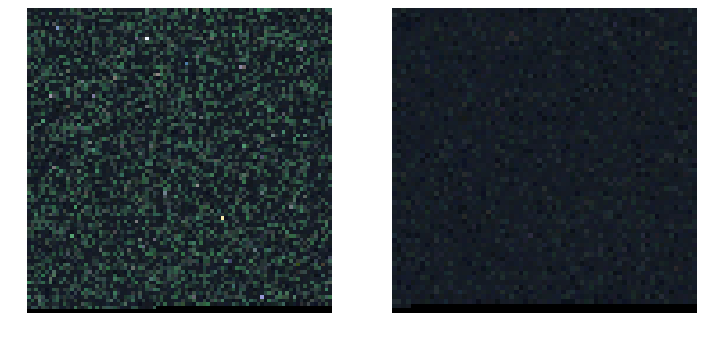

In [48]:
all_water = train.loc[(df['NMD']==62)]
filtered_water = train.loc[(df['NMD']==62) & (df['Band03']<0.0009)]
filters=[all_water,filtered_water]
i=0
fig,ax = plt.subplots(1,2,figsize=(12,6))
for vals in filters:
    rgb = vals[['Band02','Band03','Band04']].values
    s = np.shape(rgb)[0]
    rows = np.ceil(np.sqrt(s))
    cols = np.ceil(np.sqrt(s))

    collected_pixels=np.zeros((int(rows*cols),3))
    collected_pixels[:s,0]=rgb[:,2]
    collected_pixels[:s,1]=rgb[:,1]
    collected_pixels[:s,2]=rgb[:,0]
    collected_pixels=(200.*collected_pixels)#.astype(int)
    
    ax[i].imshow(collected_pixels.reshape((int(rows),int(rows),3)))
    ax[i].axis('off')
    i+=1
plt.show()


In [ ]:
train = train.drop(train[(train.NMD ==62 ) & (train.Band03>0.0009)].index)

1. Look at the urban class and see how well this class is predicted and how the urban classification according to NMD data looks in the satellite image. 
2. Make a new bar plot and see how many pixels there is in each class.

3. Train the model with the cleaned dataand see if there is any differnce.
4. The model above is trained with all bands. Try to retrain it by removing bands that  might be duplications of other bands or that might be to low in resolution. Any differance?